# 1. Seq2Seq

Sequence-to-Sequence (Seq2Seq) 모델은 한 시퀀스를 다른 시퀀스로 변환하기 위해 설계된 머신 러닝 모델입니다. 이는 특히 입력과 출력이 모두 시퀀스인 작업, 예를 들어 언어 번역, 텍스트 요약, 음성 인식 등에 유용합니다.



일반적인 Seq2Seq 모델은 두 가지 주요 구성 요소로 이루어져 있습니다:
- 인코더 (Encoder): 인코더는 입력 시퀀스를 처리하여 고정 크기의 컨텍스트 벡터로 변환합니다. 이 컨텍스트 벡터는 입력 시퀀스 전체의 의미를 포착하도록 설계되었습니다.
- 디코더 (Decoder): 디코더는 인코더로부터 받은 컨텍스트 벡터를 사용하여 출력 시퀀스를 단계별로 생성합니다.


---

 Seq2Seq 모델을 이용해서 간단한 한영 번역기를 만들어보겠습니다.

 ai-hub의 한국어-영어 번역 말뭉치 데이터 중 대화체 데이터를 활용하겠습니다.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd

from collections import Counter
import time
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from transformers import BertTokenizer
# konlpy, nltk --> 형태소, 단어

# Bert에서 사용하는 토크나이저
# bert-base-multilingual-cased : 여러 언어를 지원하도록 훈련된 Bert모델의 토크나이저
# 훈련 데이터에서 자주 나타나는 단어는 그대로 사용하고, 덜 자주 나타나는 단어는 더 작은 단위로 분해
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

/home/kimjt/anaconda3/envs/torch/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
device

device(type='cuda')

In [ ]:
# 데이터 불러오기
df = pd.read_excel('./data/NLP_data/2_대화체.xlsx')

df

,대분류,소분류,상황,Set Nr.,발화자,원문,번역문
0,비즈니스,회의,의견 교환하기,1,A-1,이번 신제품 출시에 대한 시장의 반응은 어떤가요?,How is the market's reaction to the newly rele...
1,비즈니스,회의,의견 교환하기,1,B-1,판매량이 지난번 제품보다 빠르게 늘고 있습니다.,The sales increase is faster than the previous...
2,비즈니스,회의,의견 교환하기,1,A-2,그렇다면 공장에 연락해서 주문량을 더 늘려야겠네요.,"Then, we'll have to call the manufacturer and ..."
3,비즈니스,회의,의견 교환하기,1,B-2,"네, 제가 연락해서 주문량을 2배로 늘리겠습니다.","Sure, I'll make a call and double the volume o..."
4,비즈니스,회의,의견 교환하기,2,A-1,지난 회의 마지막에 논의했던 안건을 다시 볼까요?,Shall we take a look at the issues we discusse...
...,...,...,...,...,...,...,...
99995,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",24999,B-2,"저희가 가격표 배치를 잘못해서 혼동을 드렸나 봐요, 죄송해요.",It seems that we didn't place the price tags c...
99996,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",25000,A-1,"백화점 포인트로 계산하고 싶은데, 가능한가요?",Can I pay using the department store points?
99997,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",25000,B-1,"네, 물론이죠, 전화번호 입력해주시면 됩니다.","Yes, of course, you just need to enter your ph..."
99998,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",25000,A-2,"입력했어요, 전액 백화점 포인트로 결제하고 싶어요.","I entered it, I want to pay it with all the de..."


In [ ]:
sentence = "밥을 먹었습니다."
tokenizer.tokenize(sentence)

['밥', '##을', '먹', '##었', '##습', '##니다', '.']

훈련 과정에서는 이전 시점의 디코더 셀의 출력을 현재 시점의 디코더 셀의 입력으로 넣어주지 않고, 이전 시점의 실제값을 현재 시점의 디코더 셀의 입력값으로 하는 방법을 사용합니다.(교사 강요((Teacher Forcing)))

<br>

교사 강요를 위해 데이터는 총 3가지를 준비해야 합니다.

- 원문 입력 : 번역할 문장(여기서는 한국어 문장)
- 번역문 입력 : 시작 토큰과 번역된 문장(여기서는 영어 문장) - 교사학습 시 입력으로 넣어줌
- 번역문 출력 : 번역된 문장과 종료 토큰 - 실제 정답

ex)
- src_in : '나는 학생입니다.'
- trg_in : '[sos] I am a student.'
- trg_out : 'I am a student.[eos]'


In [ ]:
# 원문(한국어) 토큰화

def preprocess_src(text):
    tokens = tokenizer.tokenize(text)
    return tokens

In [ ]:
sample = 'I am a student'

['<sos>'] + tokenizer.tokenize((sample))

['<sos>', 'I', 'am', 'a', 'student']

In [ ]:
# 번역문(영어) 입력, 출력 토큰화

def preprocess_trg_in(text):
  text = ['<sos>'] + tokenizer.tokenize((text))
  return text

def preprocess_trg_out(text):
  text = tokenizer.tokenize((text)) + ['<eos>']
  return text

토큰화 함수를 활용해 기존 데이프레임에 토큰화 한 컬럼을 추가합니다.

In [ ]:
df['src_in'] = df['원문'].apply(lambda x : preprocess_src(x))
df['trg_in'] = df['번역문'].apply(lambda x : preprocess_trg_in(x))
df['trg_out'] = df['번역문'].apply(lambda x : preprocess_trg_out(x))

In [ ]:
df

,대분류,소분류,상황,Set Nr.,발화자,원문,번역문,src_in,trg_in,trg_out
0,비즈니스,회의,의견 교환하기,1,A-1,이번 신제품 출시에 대한 시장의 반응은 어떤가요?,How is the market's reaction to the newly rele...,"[이, ##번, 신, ##제, ##품, 출, ##시, ##에, 대한, 시, ##장의...","[<sos>, How, is, the, market, ', s, reaction, ...","[How, is, the, market, ', s, reaction, to, the..."
1,비즈니스,회의,의견 교환하기,1,B-1,판매량이 지난번 제품보다 빠르게 늘고 있습니다.,The sales increase is faster than the previous...,"[판, ##매, ##량, ##이, 지, ##난, ##번, 제, ##품, ##보다, ...","[<sos>, The, sales, increase, is, faster, than...","[The, sales, increase, is, faster, than, the, ..."
2,비즈니스,회의,의견 교환하기,1,A-2,그렇다면 공장에 연락해서 주문량을 더 늘려야겠네요.,"Then, we'll have to call the manufacturer and ...","[그, ##렇, ##다, ##면, 공, ##장에, 연, ##락, ##해서, 주, #...","[<sos>, Then, ,, we, ', ll, have, to, call, th...","[Then, ,, we, ', ll, have, to, call, the, manu..."
3,비즈니스,회의,의견 교환하기,1,B-2,"네, 제가 연락해서 주문량을 2배로 늘리겠습니다.","Sure, I'll make a call and double the volume o...","[네, ,, 제, ##가, 연, ##락, ##해서, 주, ##문, ##량, ##을,...","[<sos>, Sur, ##e, ,, I, ', ll, make, a, call, ...","[Sur, ##e, ,, I, ', ll, make, a, call, and, do..."
4,비즈니스,회의,의견 교환하기,2,A-1,지난 회의 마지막에 논의했던 안건을 다시 볼까요?,Shall we take a look at the issues we discusse...,"[지, ##난, 회, ##의, 마지막, ##에, 논, ##의, ##했던, 안, ##...","[<sos>, Sha, ##ll, we, take, a, look, at, the,...","[Sha, ##ll, we, take, a, look, at, the, issues..."
...,...,...,...,...,...,...,...,...,...,...
99995,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",24999,B-2,"저희가 가격표 배치를 잘못해서 혼동을 드렸나 봐요, 죄송해요.",It seems that we didn't place the price tags c...,"[저, ##희, ##가, 가, ##격, ##표, 배, ##치를, 잘, ##못, ##...","[<sos>, It, seems, that, we, didn, ', t, place...","[It, seems, that, we, didn, ', t, place, the, ..."
99996,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",25000,A-1,"백화점 포인트로 계산하고 싶은데, 가능한가요?",Can I pay using the department store points?,"[백, ##화, ##점, 포, ##인, ##트, ##로, 계, ##산, ##하고, ...","[<sos>, Can, I, pay, using, the, department, s...","[Can, I, pay, using, the, department, store, p..."
99997,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",25000,B-1,"네, 물론이죠, 전화번호 입력해주시면 됩니다.","Yes, of course, you just need to enter your ph...","[네, ,, 물, ##론, ##이, ##죠, ,, 전, ##화, ##번, ##호, ...","[<sos>, Yes, ,, of, course, ,, you, just, need...","[Yes, ,, of, course, ,, you, just, need, to, e..."
99998,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",25000,A-2,"입력했어요, 전액 백화점 포인트로 결제하고 싶어요.","I entered it, I want to pay it with all the de...","[입, ##력, ##했, ##어, ##요, ,, 전, ##액, 백, ##화, ##점...","[<sos>, I, entered, it, ,, I, want, to, pay, i...","[I, entered, it, ,, I, want, to, pay, it, with..."


In [ ]:
from transformers import ElectraTokenizer

# KoELECTRA용 Tokenizer
koele_tokenizer = ElectraTokenizer.from_pretrained('monologg/koelectra-base-v3-discriminator')
def preprocess_trg_in(text):
  text = ['<sos>'] + koele_tokenizer.tokenize((text))
  return text

def preprocess_trg_out(text):
  text = koele_tokenizer.tokenize((text)) + ['<eos>']
  return text

df['src_in'] = df['원문'].apply(lambda x : preprocess_src(x))
df['trg_in'] = df['번역문'].apply(lambda x : preprocess_trg_in(x))
df['trg_out'] = df['번역문'].apply(lambda x : preprocess_trg_out(x))
df

/home/kimjt/anaconda3/envs/torch/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


,대분류,소분류,상황,Set Nr.,발화자,원문,번역문,src_in,trg_in,trg_out
0,비즈니스,회의,의견 교환하기,1,A-1,이번 신제품 출시에 대한 시장의 반응은 어떤가요?,How is the market's reaction to the newly rele...,"[이번, 신제, ##품, 출시, ##에, 대한, 시장, ##의, 반응, ##은, 어...","[<sos>, How, is, the, mark, ##et, ', s, re, ##...","[How, is, the, mark, ##et, ', s, re, ##act, ##..."
1,비즈니스,회의,의견 교환하기,1,B-1,판매량이 지난번 제품보다 빠르게 늘고 있습니다.,The sales increase is faster than the previous...,"[판매량, ##이, 지난번, 제품, ##보, ##다, 빠르, ##게, 늘, ##고,...","[<sos>, The, sa, ##les, in, ##c, ##re, ##ase, ...","[The, sa, ##les, in, ##c, ##re, ##ase, is, fa,..."
2,비즈니스,회의,의견 교환하기,1,A-2,그렇다면 공장에 연락해서 주문량을 더 늘려야겠네요.,"Then, we'll have to call the manufacturer and ...","[그렇, ##다면, 공장, ##에, 연락, ##해서, 주문, ##량, ##을, 더,...","[<sos>, The, ##n, ,, we, ', l, ##l, have, to, ...","[The, ##n, ,, we, ', l, ##l, have, to, c, ##al..."
3,비즈니스,회의,의견 교환하기,1,B-2,"네, 제가 연락해서 주문량을 2배로 늘리겠습니다.","Sure, I'll make a call and double the volume o...","[네, ,, 제, ##가, 연락, ##해서, 주문, ##량, ##을, 2, ##배,...","[<sos>, Su, ##re, ,, I, ', l, ##l, ma, ##ke, a...","[Su, ##re, ,, I, ', l, ##l, ma, ##ke, a, c, ##..."
4,비즈니스,회의,의견 교환하기,2,A-1,지난 회의 마지막에 논의했던 안건을 다시 볼까요?,Shall we take a look at the issues we discusse...,"[지난, 회의, 마지막, ##에, 논의, ##했, ##던, 안건, ##을, 다시, ...","[<sos>, Sh, ##all, we, t, ##ake, a, l, ##ook, ...","[Sh, ##all, we, t, ##ake, a, l, ##ook, at, the..."
...,...,...,...,...,...,...,...,...,...,...
99995,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",24999,B-2,"저희가 가격표 배치를 잘못해서 혼동을 드렸나 봐요, 죄송해요.",It seems that we didn't place the price tags c...,"[저희, ##가, 가격, ##표, 배치, ##를, 잘못, ##해서, 혼동, ##을,...","[<sos>, It, se, ##em, ##s, that, we, di, ##d, ...","[It, se, ##em, ##s, that, we, di, ##d, ##n, ',..."
99996,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",25000,A-1,"백화점 포인트로 계산하고 싶은데, 가능한가요?",Can I pay using the department store points?,"[백화점, 포인트, ##로, 계산, ##하, ##고, 싶, ##은, ##데, ,, ...","[<sos>, Can, I, p, ##ay, us, ##ing, the, de, #...","[Can, I, p, ##ay, us, ##ing, the, de, ##pa, ##..."
99997,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",25000,B-1,"네, 물론이죠, 전화번호 입력해주시면 됩니다.","Yes, of course, you just need to enter your ph...","[네, ,, 물론, ##이, ##죠, ,, 전화, ##번, ##호, 입력, ##해,...","[<sos>, Y, ##es, ,, of, co, ##ur, ##se, ,, you...","[Y, ##es, ,, of, co, ##ur, ##se, ,, you, j, ##..."
99998,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",25000,A-2,"입력했어요, 전액 백화점 포인트로 결제하고 싶어요.","I entered it, I want to pay it with all the de...","[입력, ##했, ##어요, ,, 전액, 백화점, 포인트, ##로, 결제, ##하,...","[<sos>, I, en, ##ter, ##ed, it, ,, I, w, ##ant...","[I, en, ##ter, ##ed, it, ,, I, w, ##ant, to, p..."


In [ ]:
from transformers import MBart50TokenizerFast

ko_tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50", src_lang="ko_KR")
ko_tokenizer.tokenize("이번 신제품 출시에 대한 시장의 반응은 어떤가요?")

/home/kimjt/anaconda3/envs/torch/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


['▁이번',
 '▁신',
 '제품',
 '▁출시',
 '에',
 '▁대한',
 '▁시장',
 '의',
 '▁반응',
 '은',
 '▁어떤',
 '가요',
 '?']

In [ ]:
def preprocess_src(text, tokenizer):
    tokens = tokenizer.tokenize(text)
    return tokens

def preprocess_trg_in(text, tokenizer):
  text = ['<sos>'] + tokenizer.tokenize((text))
  return text

def preprocess_trg_out(text, tokenizer):
  text = tokenizer.tokenize((text)) + ['<eos>']
  return text

df['src_in'] = df['원문'].apply(lambda x : preprocess_src(x, ko_tokenizer))
df['trg_in'] = df['번역문'].apply(lambda x : preprocess_trg_in(x, ko_tokenizer))
df['trg_out'] = df['번역문'].apply(lambda x : preprocess_trg_out(x, ko_tokenizer))
df

,대분류,소분류,상황,Set Nr.,발화자,원문,번역문,src_in,trg_in,trg_out,src_in_len,trg_in_len
0,비즈니스,회의,의견 교환하기,1,A-1,이번 신제품 출시에 대한 시장의 반응은 어떤가요?,How is the market's reaction to the newly rele...,"[▁이번, ▁신, 제품, ▁출시, 에, ▁대한, ▁시장, 의, ▁반응, 은, ▁어떤...","[<sos>, ▁How, ▁is, ▁the, ▁market, ', s, ▁react...","[▁How, ▁is, ▁the, ▁market, ', s, ▁reaction, ▁t...",13,15
1,비즈니스,회의,의견 교환하기,1,B-1,판매량이 지난번 제품보다 빠르게 늘고 있습니다.,The sales increase is faster than the previous...,"[▁판매, 량이, ▁지난, 번, ▁제품, 보다, ▁빠르게, ▁늘, 고, ▁있습니다, .]","[<sos>, ▁The, ▁sales, ▁increase, ▁is, ▁fast, e...","[▁The, ▁sales, ▁increase, ▁is, ▁fast, er, ▁tha...",11,12
2,비즈니스,회의,의견 교환하기,1,A-2,그렇다면 공장에 연락해서 주문량을 더 늘려야겠네요.,"Then, we'll have to call the manufacturer and ...","[▁그렇다면, ▁공, 장, 에, ▁연락, 해서, ▁주문, 량을, ▁더, ▁늘, 려,...","[<sos>, ▁Then, ,, ▁we, ', ll, ▁have, ▁to, ▁cal...","[▁Then, ,, ▁we, ', ll, ▁have, ▁to, ▁call, ▁the...",15,20
3,비즈니스,회의,의견 교환하기,1,B-2,"네, 제가 연락해서 주문량을 2배로 늘리겠습니다.","Sure, I'll make a call and double the volume o...","[▁네, ,, ▁제가, ▁연락, 해서, ▁주문, 량을, ▁2, 배, 로, ▁늘, 리...","[<sos>, ▁Sur, e, ,, ▁I, ', ll, ▁make, ▁a, ▁cal...","[▁Sur, e, ,, ▁I, ', ll, ▁make, ▁a, ▁call, ▁and...",14,18
4,비즈니스,회의,의견 교환하기,2,A-1,지난 회의 마지막에 논의했던 안건을 다시 볼까요?,Shall we take a look at the issues we discusse...,"[▁지난, ▁, 회의, ▁마지막, 에, ▁논의, 했던, ▁안, 건, 을, ▁다시, ...","[<sos>, ▁S, hall, ▁we, ▁take, ▁a, ▁look, ▁at, ...","[▁S, hall, ▁we, ▁take, ▁a, ▁look, ▁at, ▁the, ▁...",14,21
...,...,...,...,...,...,...,...,...,...,...,...,...
99296,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",24999,B-2,"저희가 가격표 배치를 잘못해서 혼동을 드렸나 봐요, 죄송해요.",It seems that we didn't place the price tags c...,"[▁저희, 가, ▁가격, 표, ▁배치, 를, ▁잘못, 해서, ▁, 혼, 동, 을, ...","[<sos>, ▁It, ▁seems, ▁that, ▁we, ▁didn, ', t, ...","[▁It, ▁seems, ▁that, ▁we, ▁didn, ', t, ▁place,...",23,24
99297,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",25000,A-1,"백화점 포인트로 계산하고 싶은데, 가능한가요?",Can I pay using the department store points?,"[▁, 백화점, ▁포인트, 로, ▁계산, 하고, ▁싶은, 데, ,, ▁가능한, 가요...","[<sos>, ▁Can, ▁I, ▁pay, ▁using, ▁the, ▁departm...","[▁Can, ▁I, ▁pay, ▁using, ▁the, ▁department, ▁s...",12,10
99298,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",25000,B-1,"네, 물론이죠, 전화번호 입력해주시면 됩니다.","Yes, of course, you just need to enter your ph...","[▁네, ,, ▁물론, 이죠, ,, ▁전화, 번호, ▁입력, 해, 주시면, ▁됩니다...","[<sos>, ▁Yes, ,, ▁of, ▁course, ,, ▁you, ▁just,...","[▁Yes, ,, ▁of, ▁course, ,, ▁you, ▁just, ▁need,...",12,15
99299,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",25000,A-2,"입력했어요, 전액 백화점 포인트로 결제하고 싶어요.","I entered it, I want to pay it with all the de...","[▁입력, 했어요, ,, ▁전, 액, ▁, 백화점, ▁포인트, 로, ▁결제, 하고,...","[<sos>, ▁I, ▁enter, ed, ▁it, ,, ▁I, ▁want, ▁to...","[▁I, ▁enter, ed, ▁it, ,, ▁I, ▁want, ▁to, ▁pay,...",14,18


In [ ]:
# # 저장
# df.to_csv('translation_data.csv',index=False)

In [ ]:
df = pd.read_csv('translation_data.csv')

In [ ]:
df

,대분류,소분류,상황,Set Nr.,발화자,원문,번역문,src_in,trg_in,trg_out
0,비즈니스,회의,의견 교환하기,1,A-1,이번 신제품 출시에 대한 시장의 반응은 어떤가요?,How is the market's reaction to the newly rele...,"[▁이번, ▁신, 제품, ▁출시, 에, ▁대한, ▁시장, 의, ▁반응, 은, ▁어떤...","[<sos>, ▁How, ▁is, ▁the, ▁market, ', s, ▁react...","[▁How, ▁is, ▁the, ▁market, ', s, ▁reaction, ▁t..."
1,비즈니스,회의,의견 교환하기,1,B-1,판매량이 지난번 제품보다 빠르게 늘고 있습니다.,The sales increase is faster than the previous...,"[▁판매, 량이, ▁지난, 번, ▁제품, 보다, ▁빠르게, ▁늘, 고, ▁있습니다, .]","[<sos>, ▁The, ▁sales, ▁increase, ▁is, ▁fast, e...","[▁The, ▁sales, ▁increase, ▁is, ▁fast, er, ▁tha..."
2,비즈니스,회의,의견 교환하기,1,A-2,그렇다면 공장에 연락해서 주문량을 더 늘려야겠네요.,"Then, we'll have to call the manufacturer and ...","[▁그렇다면, ▁공, 장, 에, ▁연락, 해서, ▁주문, 량을, ▁더, ▁늘, 려,...","[<sos>, ▁Then, ,, ▁we, ', ll, ▁have, ▁to, ▁cal...","[▁Then, ,, ▁we, ', ll, ▁have, ▁to, ▁call, ▁the..."
3,비즈니스,회의,의견 교환하기,1,B-2,"네, 제가 연락해서 주문량을 2배로 늘리겠습니다.","Sure, I'll make a call and double the volume o...","[▁네, ,, ▁제가, ▁연락, 해서, ▁주문, 량을, ▁2, 배, 로, ▁늘, 리...","[<sos>, ▁Sur, e, ,, ▁I, ', ll, ▁make, ▁a, ▁cal...","[▁Sur, e, ,, ▁I, ', ll, ▁make, ▁a, ▁call, ▁and..."
4,비즈니스,회의,의견 교환하기,2,A-1,지난 회의 마지막에 논의했던 안건을 다시 볼까요?,Shall we take a look at the issues we discusse...,"[▁지난, ▁, 회의, ▁마지막, 에, ▁논의, 했던, ▁안, 건, 을, ▁다시, ...","[<sos>, ▁S, hall, ▁we, ▁take, ▁a, ▁look, ▁at, ...","[▁S, hall, ▁we, ▁take, ▁a, ▁look, ▁at, ▁the, ▁..."
...,...,...,...,...,...,...,...,...,...,...
99995,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",24999,B-2,"저희가 가격표 배치를 잘못해서 혼동을 드렸나 봐요, 죄송해요.",It seems that we didn't place the price tags c...,"[▁저희, 가, ▁가격, 표, ▁배치, 를, ▁잘못, 해서, ▁, 혼, 동, 을, ...","[<sos>, ▁It, ▁seems, ▁that, ▁we, ▁didn, ', t, ...","[▁It, ▁seems, ▁that, ▁we, ▁didn, ', t, ▁place,..."
99996,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",25000,A-1,"백화점 포인트로 계산하고 싶은데, 가능한가요?",Can I pay using the department store points?,"[▁, 백화점, ▁포인트, 로, ▁계산, 하고, ▁싶은, 데, ,, ▁가능한, 가요...","[<sos>, ▁Can, ▁I, ▁pay, ▁using, ▁the, ▁departm...","[▁Can, ▁I, ▁pay, ▁using, ▁the, ▁department, ▁s..."
99997,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",25000,B-1,"네, 물론이죠, 전화번호 입력해주시면 됩니다.","Yes, of course, you just need to enter your ph...","[▁네, ,, ▁물론, 이죠, ,, ▁전화, 번호, ▁입력, 해, 주시면, ▁됩니다...","[<sos>, ▁Yes, ,, ▁of, ▁course, ,, ▁you, ▁just,...","[▁Yes, ,, ▁of, ▁course, ,, ▁you, ▁just, ▁need,..."
99998,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",25000,A-2,"입력했어요, 전액 백화점 포인트로 결제하고 싶어요.","I entered it, I want to pay it with all the de...","[▁입력, 했어요, ,, ▁전, 액, ▁, 백화점, ▁포인트, 로, ▁결제, 하고,...","[<sos>, ▁I, ▁enter, ed, ▁it, ,, ▁I, ▁want, ▁to...","[▁I, ▁enter, ed, ▁it, ,, ▁I, ▁want, ▁to, ▁pay,..."


In [ ]:
# 리스트는 저장되면서 문자열로 바뀌기 때문에 다시 리스트로 변경 --> 하지만 애초에......

import ast

# ast.literal_eval : 문자열을 리스트형태로 변경
df['src_in'] = df['src_in'].apply(ast.literal_eval)
df['trg_in'] = df['trg_in'].apply(ast.literal_eval)
df['trg_out'] = df['trg_out'].apply(ast.literal_eval)

다음으로 단어 집합을 만드는 함수를 생성합니다.

한국어, 영어 사전을 각각 만들어야 하고, 사전에서 패딩 토큰은 0번, Unknown 토큰은 1번으로 인코딩 되도록 설정합니다.

또한 빈도수를 기반으로 많이 등장할수록 낮은 인덱스를 부여합니다.

In [ ]:
def build_vocab(sents):
  word_list = []

  for sent in sents:
      for word in sent:
        word_list.append(word)

  # 각 단어별 등장 빈도를 계산하여 등장 빈도가 높은 순서로 정렬
  # Counter는 단어를 키(key), 등장 빈도를 값(value)으로 가지도록 반환
  word_counts = Counter(word_list)
  vocab = sorted(word_counts, key=word_counts.get, reverse=True)

  word_to_index = {}
  word_to_index['<PAD>'] = 0
  word_to_index['<UNK>'] = 1

  # 등장 빈도가 높은 단어일수록 낮은 정수를 부여
  for index, word in enumerate(vocab) :
    if word != '<PAD>':
        word_to_index[word] = index + 2

  return word_to_index

In [ ]:
src_input = df['src_in'].to_list()
trg_input = df['trg_in'].to_list()
trg_output = df['trg_out'].to_list()

src_vocab = build_vocab(src_input)
tar_vocab = build_vocab(trg_input + trg_output)

src_vocab_size = len(src_vocab)
tar_vocab_size = len(tar_vocab)
print("한국어 단어 집합의 크기 : {:d}, 영어 단어 집합의 크기 : {:d}".format(src_vocab_size, tar_vocab_size))

한국어 단어 집합의 크기 : 5730, 영어어 단어 집합의 크기 : 11320


In [ ]:
tar_vocab

{'<PAD>': 0,
 '<UNK>': 1,
 '.': 2,
 '▁I': 3,
 '▁the': 4,
 ',': 5,
 '<sos>': 6,
 '<eos>': 7,
 "'": 8,
 '▁to': 9,
 '▁you': 10,
 's': 11,
 '?': 12,
 '▁a': 13,
 '▁it': 14,
 '▁is': 15,
 '▁and': 16,
 't': 17,
 '▁for': 18,
 '▁so': 19,
 '▁in': 20,
 '▁of': 21,
 '▁have': 22,
 '▁can': 23,
 '▁that': 24,
 '▁but': 25,
 '▁be': 26,
 '▁on': 27,
 '▁we': 28,
 '▁are': 29,
 '▁will': 30,
 '▁this': 31,
 '▁there': 32,
 '▁It': 33,
 '▁me': 34,
 '▁do': 35,
 'ed': 36,
 'm': 37,
 '▁with': 38,
 '▁at': 39,
 '▁my': 40,
 'll': 41,
 '▁think': 42,
 '▁like': 43,
 '▁if': 44,
 '▁your': 45,
 '▁get': 46,
 '▁go': 47,
 '▁was': 48,
 '▁as': 49,
 '▁time': 50,
 '▁because': 51,
 '▁not': 52,
 '▁The': 53,
 'ing': 54,
 'd': 55,
 '▁don': 56,
 '▁You': 57,
 '▁take': 58,
 '▁Yes': 59,
 '▁from': 60,
 '▁about': 61,
 '▁need': 62,
 '▁an': 63,
 '▁want': 64,
 '▁here': 65,
 '▁We': 66,
 '▁right': 67,
 '▁Then': 68,
 '-': 69,
 '▁would': 70,
 '▁should': 71,
 '▁know': 72,
 '▁what': 73,
 '▁one': 74,
 '▁too': 75,
 '▁out': 76,
 '▁please': 77,
 '▁when': 7

토큰을 숫자로 인코딩하는 딕셔너리를 생성했습니다

반대로 숫자를 토큰으로 바꿔주는 딕셔너리도 미리 생성해두겠습니다.

In [ ]:
index_to_src = {v: k for k, v in src_vocab.items()}
index_to_tar = {v: k for k, v in tar_vocab.items()}

index_to_src

{0: '<PAD>',
 1: '<UNK>',
 2: '.',
 3: '▁',
 4: '?',
 5: ',',
 6: '이',
 7: '에',
 8: '요',
 9: '을',
 10: '가',
 11: '은',
 12: '도',
 13: '서',
 14: '는',
 15: '를',
 16: '▁수',
 17: '지',
 18: '로',
 19: '해',
 20: '고',
 21: '▁것',
 22: '데',
 23: '게',
 24: '어',
 25: '야',
 26: '에서',
 27: '▁이',
 28: '▁그',
 29: '▁네',
 30: '▁안',
 31: '▁거',
 32: '으로',
 33: '만',
 34: '는데',
 35: '▁가',
 36: '한',
 37: '나요',
 38: '가요',
 39: '면',
 40: '할',
 41: '아',
 42: '일',
 43: '시',
 44: '▁건',
 45: '▁한',
 46: '▁제가',
 47: '네요',
 48: '▁있는',
 49: '의',
 50: '어요',
 51: '하고',
 52: '▁그럼',
 53: '기',
 54: '주',
 55: '▁나',
 56: '▁다',
 57: '까요',
 58: '▁너무',
 59: '▁더',
 60: '▁어',
 61: '실',
 62: '인',
 63: '니까',
 64: '▁있나요',
 65: '▁할',
 66: '▁지금',
 67: '▁잘',
 68: '▁내',
 69: '겠',
 70: '▁해',
 71: '▁같',
 72: '▁게',
 73: '해서',
 74: '드릴',
 75: '하',
 76: '▁좀',
 77: '▁혹시',
 78: '하는',
 79: '▁주',
 80: '▁있습니다',
 81: '까지',
 82: '▁저',
 83: '셔',
 84: '▁아',
 85: '겠습니다',
 86: '니',
 87: '라',
 88: '▁되',
 89: '▁저희',
 90: '입니다',
 91: '▁오늘',
 92: '▁다른',
 93

이제 단어사전을 모두 만들었기 때문에, 인코딩을 위한 준비를 진행해야 합니다.


먼저 각 문장의 길이를 어떻게 맞출지 확인해보겠습니다.

In [ ]:
# 각 문장의 길이(토큰 수)를 체크하여 새로운 컬럼으로 추가
df['src_in_len'] = df['src_in'].apply(len)
df['trg_in_len'] = df['trg_in'].apply(len)

In [ ]:
df

,대분류,소분류,상황,Set Nr.,발화자,원문,번역문,src_in,trg_in,trg_out,src_in_len,trg_in_len
0,비즈니스,회의,의견 교환하기,1,A-1,이번 신제품 출시에 대한 시장의 반응은 어떤가요?,How is the market's reaction to the newly rele...,"[▁이번, ▁신, 제품, ▁출시, 에, ▁대한, ▁시장, 의, ▁반응, 은, ▁어떤...","[<sos>, ▁How, ▁is, ▁the, ▁market, ', s, ▁react...","[▁How, ▁is, ▁the, ▁market, ', s, ▁reaction, ▁t...",13,15
1,비즈니스,회의,의견 교환하기,1,B-1,판매량이 지난번 제품보다 빠르게 늘고 있습니다.,The sales increase is faster than the previous...,"[▁판매, 량이, ▁지난, 번, ▁제품, 보다, ▁빠르게, ▁늘, 고, ▁있습니다, .]","[<sos>, ▁The, ▁sales, ▁increase, ▁is, ▁fast, e...","[▁The, ▁sales, ▁increase, ▁is, ▁fast, er, ▁tha...",11,12
2,비즈니스,회의,의견 교환하기,1,A-2,그렇다면 공장에 연락해서 주문량을 더 늘려야겠네요.,"Then, we'll have to call the manufacturer and ...","[▁그렇다면, ▁공, 장, 에, ▁연락, 해서, ▁주문, 량을, ▁더, ▁늘, 려,...","[<sos>, ▁Then, ,, ▁we, ', ll, ▁have, ▁to, ▁cal...","[▁Then, ,, ▁we, ', ll, ▁have, ▁to, ▁call, ▁the...",15,20
3,비즈니스,회의,의견 교환하기,1,B-2,"네, 제가 연락해서 주문량을 2배로 늘리겠습니다.","Sure, I'll make a call and double the volume o...","[▁네, ,, ▁제가, ▁연락, 해서, ▁주문, 량을, ▁2, 배, 로, ▁늘, 리...","[<sos>, ▁Sur, e, ,, ▁I, ', ll, ▁make, ▁a, ▁cal...","[▁Sur, e, ,, ▁I, ', ll, ▁make, ▁a, ▁call, ▁and...",14,18
4,비즈니스,회의,의견 교환하기,2,A-1,지난 회의 마지막에 논의했던 안건을 다시 볼까요?,Shall we take a look at the issues we discusse...,"[▁지난, ▁, 회의, ▁마지막, 에, ▁논의, 했던, ▁안, 건, 을, ▁다시, ...","[<sos>, ▁S, hall, ▁we, ▁take, ▁a, ▁look, ▁at, ...","[▁S, hall, ▁we, ▁take, ▁a, ▁look, ▁at, ▁the, ▁...",14,21
...,...,...,...,...,...,...,...,...,...,...,...,...
99296,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",24999,B-2,"저희가 가격표 배치를 잘못해서 혼동을 드렸나 봐요, 죄송해요.",It seems that we didn't place the price tags c...,"[▁저희, 가, ▁가격, 표, ▁배치, 를, ▁잘못, 해서, ▁, 혼, 동, 을, ...","[<sos>, ▁It, ▁seems, ▁that, ▁we, ▁didn, ', t, ...","[▁It, ▁seems, ▁that, ▁we, ▁didn, ', t, ▁place,...",23,24
99297,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",25000,A-1,"백화점 포인트로 계산하고 싶은데, 가능한가요?",Can I pay using the department store points?,"[▁, 백화점, ▁포인트, 로, ▁계산, 하고, ▁싶은, 데, ,, ▁가능한, 가요...","[<sos>, ▁Can, ▁I, ▁pay, ▁using, ▁the, ▁departm...","[▁Can, ▁I, ▁pay, ▁using, ▁the, ▁department, ▁s...",12,10
99298,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",25000,B-1,"네, 물론이죠, 전화번호 입력해주시면 됩니다.","Yes, of course, you just need to enter your ph...","[▁네, ,, ▁물론, 이죠, ,, ▁전화, 번호, ▁입력, 해, 주시면, ▁됩니다...","[<sos>, ▁Yes, ,, ▁of, ▁course, ,, ▁you, ▁just,...","[▁Yes, ,, ▁of, ▁course, ,, ▁you, ▁just, ▁need,...",12,15
99299,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",25000,A-2,"입력했어요, 전액 백화점 포인트로 결제하고 싶어요.","I entered it, I want to pay it with all the de...","[▁입력, 했어요, ,, ▁전, 액, ▁, 백화점, ▁포인트, 로, ▁결제, 하고,...","[<sos>, ▁I, ▁enter, ed, ▁it, ,, ▁I, ▁want, ▁to...","[▁I, ▁enter, ed, ▁it, ,, ▁I, ▁want, ▁to, ▁pay,...",14,18


count    99301.000000
mean        16.457770
std          3.926636
min          2.000000
25%         14.000000
50%         16.000000
75%         19.000000
max         30.000000
Name: src_in_len, dtype: float64
count    99301.000000
mean        17.602753
std          4.772438
min          4.000000
25%         14.000000
50%         17.000000
75%         20.000000
max         54.000000
Name: trg_in_len, dtype: float64


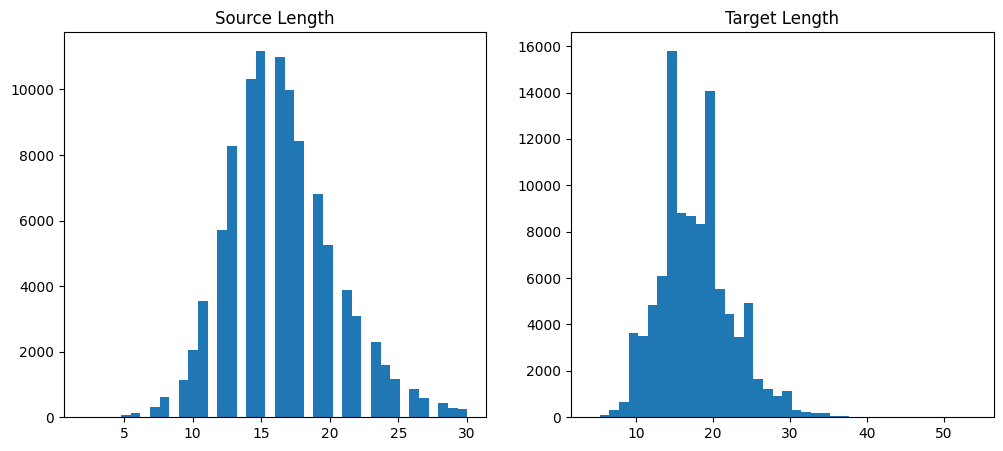

In [ ]:
print(df['src_in_len'].describe())
print(df['trg_in_len'].describe())

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].hist(df['src_in_len'], bins=40)
ax[0].set_title('Source Length')
ax[1].hist(df['trg_in_len'], bins=40)
ax[1].set_title('Target Length')
plt.show()

가장 길이가 짧은 문장은 토큰 2개, 가장 긴문장은 80개, 평균은 16개의 토큰으로 이루어진 문장이라는것을 확인할 수 있습니다.

75%의 값도 토큰 길이가 19개이기 때문에, 토큰수가 80개인 문장처럼 긴 문장은 많지 않다는 것을 짐작할 수 있습니다.

원문의 최대 토큰수를 30으로 설정하고, 이를 넘어가는 데이터는 모두 제거하겠습니다.

In [ ]:
# src_in_len이 30보다 큰 행 제거
df = df[df['src_in_len'] <= 30].reset_index(drop=True)

df

,대분류,소분류,상황,Set Nr.,발화자,원문,번역문,src_in,trg_in,trg_out,src_in_len,trg_in_len
0,비즈니스,회의,의견 교환하기,1,A-1,이번 신제품 출시에 대한 시장의 반응은 어떤가요?,How is the market's reaction to the newly rele...,"[▁이번, ▁신, 제품, ▁출시, 에, ▁대한, ▁시장, 의, ▁반응, 은, ▁어떤...","[<sos>, ▁How, ▁is, ▁the, ▁market, ', s, ▁react...","[▁How, ▁is, ▁the, ▁market, ', s, ▁reaction, ▁t...",13,15
1,비즈니스,회의,의견 교환하기,1,B-1,판매량이 지난번 제품보다 빠르게 늘고 있습니다.,The sales increase is faster than the previous...,"[▁판매, 량이, ▁지난, 번, ▁제품, 보다, ▁빠르게, ▁늘, 고, ▁있습니다, .]","[<sos>, ▁The, ▁sales, ▁increase, ▁is, ▁fast, e...","[▁The, ▁sales, ▁increase, ▁is, ▁fast, er, ▁tha...",11,12
2,비즈니스,회의,의견 교환하기,1,A-2,그렇다면 공장에 연락해서 주문량을 더 늘려야겠네요.,"Then, we'll have to call the manufacturer and ...","[▁그렇다면, ▁공, 장, 에, ▁연락, 해서, ▁주문, 량을, ▁더, ▁늘, 려,...","[<sos>, ▁Then, ,, ▁we, ', ll, ▁have, ▁to, ▁cal...","[▁Then, ,, ▁we, ', ll, ▁have, ▁to, ▁call, ▁the...",15,20
3,비즈니스,회의,의견 교환하기,1,B-2,"네, 제가 연락해서 주문량을 2배로 늘리겠습니다.","Sure, I'll make a call and double the volume o...","[▁네, ,, ▁제가, ▁연락, 해서, ▁주문, 량을, ▁2, 배, 로, ▁늘, 리...","[<sos>, ▁Sur, e, ,, ▁I, ', ll, ▁make, ▁a, ▁cal...","[▁Sur, e, ,, ▁I, ', ll, ▁make, ▁a, ▁call, ▁and...",14,18
4,비즈니스,회의,의견 교환하기,2,A-1,지난 회의 마지막에 논의했던 안건을 다시 볼까요?,Shall we take a look at the issues we discusse...,"[▁지난, ▁, 회의, ▁마지막, 에, ▁논의, 했던, ▁안, 건, 을, ▁다시, ...","[<sos>, ▁S, hall, ▁we, ▁take, ▁a, ▁look, ▁at, ...","[▁S, hall, ▁we, ▁take, ▁a, ▁look, ▁at, ▁the, ▁...",14,21
...,...,...,...,...,...,...,...,...,...,...,...,...
99296,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",24999,B-2,"저희가 가격표 배치를 잘못해서 혼동을 드렸나 봐요, 죄송해요.",It seems that we didn't place the price tags c...,"[▁저희, 가, ▁가격, 표, ▁배치, 를, ▁잘못, 해서, ▁, 혼, 동, 을, ...","[<sos>, ▁It, ▁seems, ▁that, ▁we, ▁didn, ', t, ...","[▁It, ▁seems, ▁that, ▁we, ▁didn, ', t, ▁place,...",23,24
99297,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",25000,A-1,"백화점 포인트로 계산하고 싶은데, 가능한가요?",Can I pay using the department store points?,"[▁, 백화점, ▁포인트, 로, ▁계산, 하고, ▁싶은, 데, ,, ▁가능한, 가요...","[<sos>, ▁Can, ▁I, ▁pay, ▁using, ▁the, ▁departm...","[▁Can, ▁I, ▁pay, ▁using, ▁the, ▁department, ▁s...",12,10
99298,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",25000,B-1,"네, 물론이죠, 전화번호 입력해주시면 됩니다.","Yes, of course, you just need to enter your ph...","[▁네, ,, ▁물론, 이죠, ,, ▁전화, 번호, ▁입력, 해, 주시면, ▁됩니다...","[<sos>, ▁Yes, ,, ▁of, ▁course, ,, ▁you, ▁just,...","[▁Yes, ,, ▁of, ▁course, ,, ▁you, ▁just, ▁need,...",12,15
99299,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",25000,A-2,"입력했어요, 전액 백화점 포인트로 결제하고 싶어요.","I entered it, I want to pay it with all the de...","[▁입력, 했어요, ,, ▁전, 액, ▁, 백화점, ▁포인트, 로, ▁결제, 하고,...","[<sos>, ▁I, ▁enter, ed, ▁it, ,, ▁I, ▁want, ▁to...","[▁I, ▁enter, ed, ▁it, ,, ▁I, ▁want, ▁to, ▁pay,...",14,18


대략 2000개 정도의 문장이 제거되었습니다.

지나치게 긴 문장은 제거했기 때문에, 원문과 번역문은 남은 데이터 중 최대 토큰 수로 길이를 맞추는 패딩작업을 진행하겠습니다.

패딩처리와 동시에 만들어둔 단어 사전을 활용해서 각 토큰에 대한 인코딩 작업도 함께 진행하겠습니다.

In [ ]:
# 원문과 번역문 최대 길이 확인

src_length= int(df['src_in_len'].max())
trg_length = int(df['trg_in_len'].max())
src_length, trg_length

(30, 54)

In [ ]:
# 원문 패딩 및 인코딩
def src_encoding(tokens):
    # (src_length - 토큰 수) 만큼 패딩토큰 추가
    tokens = tokens + ['<PAD>'] *  (src_length - len(tokens))

    # 인코딩 된 숫자를 담아 둘 리스트
    index_sequences = []

    # 문장에서 토큰을 꺼내오며
    for word in tokens:
      try: # 토큰 인코딩 (단어 사전에 없는 토큰이 들어오면 except로)
          index_sequences.append(src_vocab[word])
      except KeyError: # 단어 사전에 없는 토큰이 들어오면 '<UNK>' 토큰의 숫자로 변환
          index_sequences.append(src_vocab['<UNK>'])

    return index_sequences

In [ ]:
# 번역문 패딩 및 인코딩
def trg_encoding(tokens):
    tokens = tokens + ['<PAD>'] * (trg_length - len(tokens))
    index_sequences = []
    for word in tokens:
      try:
          index_sequences.append(tar_vocab[word])
      except KeyError:
          index_sequences.append(tar_vocab['<UNK>'])

    return index_sequences

In [ ]:
# 데이터프레임의 원문과 번역문 각각에 패딩 및 인코딩 적용
df['src_in'] = df['src_in'].apply(lambda x : src_encoding(x))
df['trg_in'] = df['trg_in'].apply(lambda x : trg_encoding(x))
df['trg_out'] = df['trg_out'].apply(lambda x : trg_encoding(x))
df

,대분류,소분류,상황,Set Nr.,발화자,원문,번역문,src_in,trg_in,trg_out,src_in_len,trg_in_len
0,비즈니스,회의,의견 교환하기,1,A-1,이번 신제품 출시에 대한 시장의 반응은 어떤가요?,How is the market's reaction to the newly rele...,"[169, 174, 1003, 1191, 7, 859, 1504, 49, 1778,...","[6, 120, 15, 4, 682, 8, 11, 2198, 9, 4, 137, 9...","[120, 15, 4, 682, 8, 11, 2198, 9, 4, 137, 91, ...",13,15
1,비즈니스,회의,의견 교환하기,1,B-1,판매량이 지난번 제품보다 빠르게 늘고 있습니다.,The sales increase is faster than the previous...,"[478, 1381, 719, 176, 150, 262, 2205, 1375, 20...","[6, 53, 362, 887, 15, 479, 140, 139, 4, 1045, ...","[53, 362, 887, 15, 479, 140, 139, 4, 1045, 113...",11,12
2,비즈니스,회의,의견 교환하기,1,A-2,그렇다면 공장에 연락해서 주문량을 더 늘려야겠네요.,"Then, we'll have to call the manufacturer and ...","[481, 466, 110, 7, 290, 73, 97, 1890, 59, 1375...","[6, 68, 5, 28, 8, 41, 22, 9, 202, 4, 2775, 436...","[68, 5, 28, 8, 41, 22, 9, 202, 4, 2775, 436, 1...",15,20
3,비즈니스,회의,의견 교환하기,1,B-2,"네, 제가 연락해서 주문량을 2배로 늘리겠습니다.","Sure, I'll make a call and double the volume o...","[29, 5, 46, 290, 73, 97, 1890, 149, 538, 18, 1...","[6, 300, 90, 5, 3, 8, 41, 111, 13, 202, 16, 11...","[300, 90, 5, 3, 8, 41, 111, 13, 202, 16, 1146,...",14,18
4,비즈니스,회의,의견 교환하기,2,A-1,지난 회의 마지막에 논의했던 안건을 다시 볼까요?,Shall we take a look at the issues we discusse...,"[719, 3, 249, 1194, 7, 2818, 667, 30, 401, 9, ...","[6, 1106, 1690, 28, 58, 13, 155, 39, 4, 1691, ...","[1106, 1690, 28, 58, 13, 155, 39, 4, 1691, 28,...",14,21
...,...,...,...,...,...,...,...,...,...,...,...,...
99296,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",24999,B-2,"저희가 가격표 배치를 잘못해서 혼동을 드렸나 봐요, 죄송해요.",It seems that we didn't place the price tags c...,"[89, 10, 291, 555, 2979, 15, 706, 73, 3, 1740,...","[6, 33, 287, 24, 28, 156, 8, 17, 195, 4, 210, ...","[33, 287, 24, 28, 156, 8, 17, 195, 4, 210, 589...",23,24
99297,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",25000,A-1,"백화점 포인트로 계산하고 싶은데, 가능한가요?",Can I pay using the department store points?,"[3, 1546, 2012, 18, 469, 51, 184, 22, 5, 284, ...","[6, 133, 3, 150, 370, 4, 318, 193, 870, 12, 0,...","[133, 3, 150, 370, 4, 318, 193, 870, 12, 7, 0,...",12,10
99298,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",25000,B-1,"네, 물론이죠, 전화번호 입력해주시면 됩니다.","Yes, of course, you just need to enter your ph...","[29, 5, 916, 1239, 5, 228, 499, 1657, 19, 221,...","[6, 59, 5, 21, 301, 5, 10, 79, 62, 9, 767, 45,...","[59, 5, 21, 301, 5, 10, 79, 62, 9, 767, 45, 27...",12,15
99299,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",25000,A-2,"입력했어요, 전액 백화점 포인트로 결제하고 싶어요.","I entered it, I want to pay it with all the de...","[1657, 678, 5, 227, 920, 3, 1546, 2012, 18, 27...","[6, 3, 767, 36, 14, 5, 3, 64, 9, 150, 14, 38, ...","[3, 767, 36, 14, 5, 3, 64, 9, 150, 14, 38, 92,...",14,18


In [ ]:
df.iloc[0]['src_in']

[169,
 174,
 1003,
 1191,
 7,
 859,
 1504,
 49,
 1778,
 11,
 129,
 38,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

패딩과 인코딩을 모두 완료했기 때문에, 이제 데이터를 훈련용과 검증용으로 분할합니다.

In [ ]:
from sklearn.model_selection import train_test_split

# 데이터프레임에서 무작위로 80%를 훈련 데이터로, 20%를 검증 데이터로 분할
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42) # 랜덤하기 하지 않기 위해서 random state 사용, 성능 향상에 영향을 미치기 않기 위함

# 결과 확인
print(f"훈련 데이터 크기: {len(train_df)}")
print(f"검증 데이터 크기: {len(valid_df)}")

훈련 데이터 크기: 79440
검증 데이터 크기: 19861


데이터 분할을 마쳤으면 데이터셋 클래스를 생성해서 모델에 넣어주기 위한 준비를 진행합니다.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class TranslationDataset(Dataset):
    def __init__(self, dataframe):
        # df로부터 원문과 번역문을 받아옴
        self.src_in = dataframe['src_in'].values
        self.trg_in = dataframe['trg_in'].values
        self.trg_out = dataframe['trg_out'].values

    def __len__(self):
        return len(self.src_in)

    def __getitem__(self, idx):
        # 텐서 형태로 변경(데이터 타입은 정수)
        src_seq = torch.tensor(self.src_in[idx], dtype=torch.long)
        trg_in_seq = torch.tensor(self.trg_in[idx], dtype=torch.long)
        trg_out_seq = torch.tensor(self.trg_out[idx], dtype=torch.long)

        return src_seq, trg_in_seq, trg_out_seq

In [ ]:
# 하이퍼파라미터 설정
BATCH_SIZE = 512

# 훈련 데이터셋 및 데이터로더
train_dataset = TranslationDataset(train_df)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# 검증 데이터셋 및 데이터로더
valid_dataset = TranslationDataset(valid_df)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
batch_sample = next(iter(train_loader))

print('src in shape :', batch_sample[0].shape)
print('trg in shape :', batch_sample[1].shape)
print('trg out shape :', batch_sample[2].shape)

src in shape : torch.Size([512, 30])
trg in shape : torch.Size([512, 54])
trg out shape : torch.Size([512, 54])


이제 본격적으로 모델을 구축합니다.

Encoder 클래스는 입력 시퀀스를 받아 해당 시퀀스의 정보를 압축하여 context vector로 변환하는 역할을 합니다. Encoder는 임베딩 레이어와 LSTM 레이어로 구성되어 있습니다. 임베딩 레이어는 입력 시퀀스의 각 토큰을 고정 크기의 벡터로 변환하고, LSTM 레이어는 시퀀스의 순서 정보를 고려하여 해당 시퀀스를 요약합니다. Encoder의 forward 메서드는 입력 시퀀스를 받아 LSTM의 hidden state와 cell state를 반환합니다.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

embedding_dim = 256
hidden_units = 512

class Encoder(nn.Module):
    def __init__(self, src_vocab_size, embedding_dim, hidden_units):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(src_vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_units, num_layers=1, batch_first=True)

    def forward(self, x):
        # 입력 데이터 차원 : (batch_size, seq_len, embedding_dim)
        x = self.embedding(x)

        # hidden.shape : (1, batch_size, hidden_units), cell.shape : (1, batch_size, hidden_units)
        _, (hidden, cell) = self.lstm(x)

        # 인코더의 출력은 hidden state, cell state
        return hidden, cell


Decoder 클래스는 Encoder에서 생성된 context vector(인코더의 마지막 은닉 상태)를 기반으로 출력 시퀀스를 생성하는 역할을 합니다. Decoder 또한 임베딩 레이어와 LSTM 레이어로 구성되어 있습니다. Decoder의 LSTM은 Encoder에서 전달받은 hidden state와 cell state를 초기 상태로 사용하여 출력 시퀀스를 생성합니다. 생성된 출력 시퀀스는 fully connected 레이어를 통과하여 각 시점의 출력 토큰에 대한 확률 분포를 얻습니다. Decoder의 forward 메서드는 입력 시퀀스, hidden state, cell state를 받아 출력 시퀀스, 업데이트된 hidden state와 cell state를 반환합니다.

In [ ]:

class Decoder(nn.Module):
    def __init__(self, tar_vocab_size, embedding_dim, hidden_units):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(tar_vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_units, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_units, tar_vocab_size) #단어의 개수 분류

    def forward(self, x, hidden, cell):

        # x.shape : (batch_size, seq_len, embedding_dim)
        x = self.embedding(x)

        # 디코더의 LSTM으로 인코더의 hidden state, cell state를 전달.
        # output.shape : (batch_size, seq_len, hidden_units)
        # hidden.shape : (1, batch_size, hidden_units)
        # cell.shape : (1, batch_size, hidden_units)
        output, (hidden, cell) = self.lstm(x, (hidden, cell))

        # output.shape: (batch_size, seq_len, tar_vocab_size)
        output = self.fc(output)
        # 텍스트 분류에서는 마지막 hidden state
        # 모든 time step마다 출력을 linear에 넣어야 한다.

        # 디코더의 출력은 예측값, hidden state, cell state
        return output, hidden, cell

Seq2Seq 클래스는 Encoder와 Decoder를 결합하여 전체 모델을 구성합니다. Seq2Seq 모델의 forward 메서드는 입력 시퀀스(src)와 출력 시퀀스(trg)를 받아 Encoder에서 생성된 은닉 상태(hidden state)와 셀 상태(cell state)를 Decoder로 전달하고, Decoder에서 생성된 출력 시퀀스를 반환합니다.

Seq2Seq의 디코더는 기본적으로 각 시점마다 다중 클래스 분류 문제를 풀고있습니다. 매 시점마다 영어 단어 집합의 크기(tar_vocab_size)의 선택지에서 단어를 1개 선택하여 이를 이번 시점에서 예측한 단어로 택합니다.

다중 클래스 분류 문제이므로 모델 학습을 위해 CrossEntropyLoss 함수를 사용하여 손실을 계산하고, Adam 옵티마이저를 사용하여 모델의 파라미터를 최적화합니다.

CrossEntropyLoss의 ignore_index 파라미터는 패딩 토큰에 해당하는 인덱스를 무시하도록 설정합니다.

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg):
        hidden, cell = self.encoder(src)

        # 훈련 중에는 디코더의 출력 중 오직 output만 사용한다.
        output, _, _ = self.decoder(trg, hidden, cell)
        return output

encoder = Encoder(src_vocab_size, embedding_dim, hidden_units)
decoder = Decoder(tar_vocab_size, embedding_dim, hidden_units)
model = Seq2Seq(encoder, decoder)

# ignore_index는 손실 계산에서 특정 인덱스를 무시하도록 설정하는 파라미터
loss_function = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters())

In [ ]:
print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5730, 256, padding_idx=0)
    (lstm): LSTM(256, 512, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(11320, 256, padding_idx=0)
    (lstm): LSTM(256, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=11320, bias=True)
  )
)


다음으로 매 epoch마다 평가를 위한 함수를 생성합니다.



In [ ]:
sample = next(iter(train_loader))

decoder_targets = sample[2]
decoder_targets

tensor([[   3,    8,   55,  ...,    0,    0,    0],
        [   3,  235,   43,  ...,    0,    0,    0],
        [1272,   10,   29,  ...,    0,    0,    0],
        ...,
        [ 108,   71,    3,  ...,    0,    0,    0],
        [  57,  281,   14,  ...,    0,    0,    0],
        [1598,    9,  304,  ...,    0,    0,    0]])

In [ ]:
mask = (decoder_targets!= 0)
mask

tensor([[ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False]])

In [ ]:
def evaluation(model, dataloader, loss_function, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_count = 0

    with torch.no_grad():
        for encoder_inputs, decoder_inputs, decoder_targets in dataloader:
            encoder_inputs = encoder_inputs.to(device)
            decoder_inputs = decoder_inputs.to(device)
            decoder_targets = decoder_targets.to(device)

            # 순전파
            # outputs.shape : (batch_size, seq_len, tar_vocab_size)
            outputs = model(encoder_inputs, decoder_inputs)

            # 손실 계산
            # outputs.view(-1, outputs.size(-1))의 shape는 (batch_size * seq_len, tar_vocab_size)
            # decoder_targets.view(-1)의 shape는 (batch_size * seq_len)
            loss = loss_function(outputs.view(-1, outputs.size(-1)), decoder_targets.view(-1))
            total_loss += loss.item()

            # 정확도 계산 (패딩 토큰 제외)
            mask = (decoder_targets != 0)
            # outputs.argmax(dim=-1) : 각 시퀀스의 각 타임스텝에서, 모델이 가장 높은 확률로 예측한 단어의 인덱스를 반환 ->(batch_size, seq_len)
            total_correct += ((outputs.argmax(dim=-1) == decoder_targets) * mask).sum().item()
            # 패딩 토큰을 제외한 전체 정답 토큰의 개수 체크
            total_count += mask.sum().item()

    return total_loss / len(dataloader), total_correct / total_count


In [ ]:
# 학습 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5730, 256, padding_idx=0)
    (lstm): LSTM(256, 512, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(11320, 256, padding_idx=0)
    (lstm): LSTM(256, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=11320, bias=True)
  )
)

In [ ]:
# Training loop
best_val_loss = 99999

for epoch in range(num_epochs):
    start_time = time.time()
    # 훈련 모드
    model.train()

    for encoder_inputs, decoder_inputs, decoder_targets in train_loader:
        encoder_inputs = encoder_inputs.to(device)
        decoder_inputs = decoder_inputs.to(device)
        decoder_targets = decoder_targets.to(device)

        # 기울기 초기화
        optimizer.zero_grad()

        # 순방향 전파
        # outputs.shape == (batch_size, seq_len, tar_vocab_size)
        outputs = model(encoder_inputs, decoder_inputs)

        # 손실 계산 및 역방향 전파
        # outputs.view(-1, outputs.size(-1))의 shape는 (batch_size * seq_len, tar_vocab_size)
        # decoder_targets.view(-1)의 shape는 (batch_size * seq_len)
        loss = loss_function(outputs.view(-1, outputs.size(-1)), decoder_targets.view(-1)) # Teacher Forcing
        loss.backward()

        # 가중치 업데이트
        optimizer.step()

    train_loss, train_acc = evaluation(model, train_loader, loss_function, device)
    valid_loss, valid_acc = evaluation(model, valid_loader, loss_function, device)

    # Epoch 종료 시간 기록 및 소요 시간 계산
    end_time = time.time()
    epoch_time = end_time - start_time

    minutes = int(epoch_time // 60)
    seconds = int(epoch_time % 60)

    print(f'Epoch: {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.4f}')
    print(f'소요시간 : {minutes}분 {seconds}초')
    print('')

    # 검증 손실이 최소일 때 체크포인트 저장
    if valid_loss < best_val_loss:
        print(f'Validation loss improved : {valid_loss:.4f}. 체크포인트 저장.')
        best_val_loss = valid_loss
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')


Epoch: 1/20 | Train Loss: 4.2858 | Train Acc: 0.2832 | Valid Loss: 4.3070 | Valid Acc: 0.2845
소요시간 : 0분 57초

Validation loss improved : 4.3070. 체크포인트 저장.
Epoch: 2/20 | Train Loss: 3.8147 | Train Acc: 0.3264 | Valid Loss: 3.8754 | Valid Acc: 0.3259
소요시간 : 0분 56초

Validation loss improved : 3.8754. 체크포인트 저장.
Epoch: 3/20 | Train Loss: 3.5547 | Train Acc: 0.3522 | Valid Loss: 3.6552 | Valid Acc: 0.3493
소요시간 : 0분 56초

Validation loss improved : 3.6552. 체크포인트 저장.
Epoch: 4/20 | Train Loss: 3.3261 | Train Acc: 0.3783 | Valid Loss: 3.4680 | Valid Acc: 0.3721
소요시간 : 0분 57초

Validation loss improved : 3.4680. 체크포인트 저장.
Epoch: 5/20 | Train Loss: 3.1404 | Train Acc: 0.4000 | Valid Loss: 3.3281 | Valid Acc: 0.3890
소요시간 : 0분 59초

Validation loss improved : 3.3281. 체크포인트 저장.
Epoch: 6/20 | Train Loss: 2.9704 | Train Acc: 0.4207 | Valid Loss: 3.2071 | Valid Acc: 0.4042
소요시간 : 1분 1초

Validation loss improved : 3.2071. 체크포인트 저장.
Epoch: 7/20 | Train Loss: 2.8302 | Train Acc: 0.4371 | Valid Loss: 3.1176 | V

저장이 잘 되었는지 확인하기 위해 저장된 모델을 불러와서 다시 평가를 진행해봅니다.

In [ ]:
del train_loader
del train_dataset

In [ ]:
torch.cuda.empty_cache()
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 420410 KiB |   5553 MiB |  33068 GiB |  33068 GiB |
|       from large pool | 420081 KiB |   5548 MiB |  32994 GiB |  32993 GiB |
|       from small pool |    329 KiB |      8 MiB |     74 GiB |     74 GiB |
|---------------------------------------------------------------------------|
| Active memory         | 420410 KiB |   5553 MiB |  33068 GiB |  33068 GiB |
|       from large pool | 420081 KiB |   5548 MiB |  32994 GiB |

In [ ]:
# 모델 로드
model.load_state_dict(torch.load('best_model_checkpoint.pth'))

# 모델을 device에 올립니다.
model.to(device)

# 검증 데이터에 대한 정확도와 손실 계산
val_loss, val_accuracy = evaluation(model, valid_loader, loss_function, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')


Best model validation loss: 2.8518
Best model validation accuracy: 0.4595


In [ ]:
# 시작토큰과 종료 토큰 확인

print(tar_vocab['<sos>'])
print(tar_vocab['<eos>'])

6
7


seq2seq는 훈련 과정(교사 강요)과 테스트 과정에서의 동작 방식이 다릅니다. 그래서 테스트 과정을 위해 모델을 다시 설계해주어야 합니다. 특히 디코더를 수정해야 합니다. 이번에는 번역 단계를 위해 모델을 수정하고 동작시켜보겠습니다.

<br>

전체적인 번역 단계를 정리하면 아래와 같습니다.

-  1) 번역하고자 하는 입력 문장이 인코더로 입력되어 인코더의 마지막 시점의 은닉 상태와 셀 상태를 얻습니다.
-  2) 인코더의 은닉 상태와 셀 상태, 시작토큰을 디코더로 보냅니다.
-  3) 디코더가 종료토큰이 나올 때까지 다음 단어를 예측하는 행동을 반복합니다.

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0):
      sentence = sentence + index_to_src[encoded_word] + ' '
  return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0 and encoded_word != tar_vocab['<sos>'] and encoded_word != tar_vocab['<eos>']):
      sentence = sentence + index_to_tar[encoded_word] + ' '
  return sentence

In [ ]:
# 인코더에서 context vector 추출 --> 모든 입력을 넣어서 출력
# 디코더 입력 : Context, time step마다 단어가 하나씩 순차적으로 입력 --> decoder에서 이전에 출력된 단어 --> EOS까지

def decode_sequence(input_seq, model, src_vocab_size, tar_vocab_size, max_output_len, int_to_src_token, int_to_tar_token):
    encoder_inputs = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)

    # 인코더의 초기 상태 설정
    hidden, cell = model.encoder(encoder_inputs)

    # 시작 토큰 <sos>을 디코더의 첫 입력으로 설정
    # unsqueeze(0)는 배치 차원을 추가하기 위함.
    decoder_input = torch.tensor([6], dtype=torch.long).unsqueeze(0).to(device)

    decoded_tokens = []

    # for문을 도는 것 == 디코더의 각 시점
    # 추론, 생성 --> ChatGPT 언어 생성 모델은 거의 다 같다.
    # decoder의 첫 단어 --> <SOS> --> <SOS> I am --> <EOS>가 나오거나 혹은 일정 길이 만큼만
    for _ in range(max_output_len):
        output, hidden, cell = model.decoder(decoder_input, hidden, cell)

        # 소프트맥스 회귀를 수행. 예측 단어의 인덱스
        output_token = output.argmax(dim=-1).item()

        # 종료 토큰 <eos>
        if output_token == 7:
            break

        # 각 시점의 단어(정수)는 decoded_tokens에 누적하였다가 최종 번역 시퀀스로 리턴합니다.
        decoded_tokens.append(output_token)

        # 현재 시점의 예측. 다음 시점의 입력으로 사용된다.
        decoder_input = torch.tensor([output_token], dtype=torch.long).unsqueeze(0).to(device)

    return ' '.join(int_to_tar_token[token] for token in decoded_tokens)


In [ ]:
valid_df['src_in']

57478    [3, 1200, 583, 952, 127, 7, 1558, 1619, 3, 122...
97321    [625, 380, 15, 392, 1226, 165, 143, 5, 1272, 1...
22279    [368, 1215, 108, 33, 513, 23, 387, 183, 2321, ...
82921    [1754, 434, 1667, 67, 98, 1499, 130, 5, 208, 1...
1570     [348, 19, 4, 217, 3, 907, 11, 56, 3, 984, 53, ...
                               ...                        
38711    [227, 5411, 643, 61, 738, 5, 804, 518, 539, 21...
12945    [2857, 3, 1205, 852, 62, 202, 11, 722, 1430, 4...
77622    [443, 532, 1225, 449, 554, 7, 709, 13, 137, 17...
58924    [293, 1392, 648, 248, 3, 1169, 6, 160, 28, 505...
36250    [204, 364, 148, 61, 141, 5, 204, 7, 3, 1864, 1...
Name: src_in, Length: 19861, dtype: object

In [1]:
from random import choices
for seq_index in choices(range(len(valid_df)), k=7):
  input_seq = valid_df['src_in'].iloc[seq_index]
  translated_text = decode_sequence(input_seq, model, src_vocab_size, tar_vocab_size, 30, index_to_src, index_to_tar).replace(' ', '').replace('▁', ' ').strip()

  print("입력문장 :",valid_df['원문'].iloc[seq_index])
  print("정답문장 :",valid_df['번역문'].iloc[seq_index])
  print("번역문장 :",translated_text)
  print("-"*50)


NameError: name 'valid_df' is not defined

In [ ]:
text = "오늘 날씨 좋네요."
input_text = preprocess_src(text, ko_tokenizer)
input_seq = src_encoding(input_text)

translated_text = decode_sequence(input_seq, model, src_vocab_size, tar_vocab_size, 20, index_to_src, index_to_tar).replace(' ', '').replace('▁', ' ').strip()

print("입력문장 :",번역할문장)
print("번역문장 :",translated_text)

입력문장 : 오늘 날씨 좋네요
번역문장 : It's a good idea today.
